In [1]:
import pandas as pd
from configparser import ConfigParser
from sqlalchemy import create_engine
import numpy as np

In [2]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

In [3]:
param_dic=config()

connect = "postgresql+psycopg2://%s:%s@%s:%s/%s" % (
param_dic['user'],
param_dic['password'],
param_dic['host'],
param_dic['port'],
param_dic['database']
)

engine=create_engine(connect, echo=False)

connection = engine.connect()

In [4]:
my_query="select timestamp,close,high,low,open,trades,turnover,volume,vwap from bitmex as bt where  bt.timestamp >= date '2018-01-01' "

In [5]:
data= connection.execute(my_query).fetchall()

In [6]:
df=pd.DataFrame(data,columns=['timestamp','close','high','low','open','trades','turnover','volume','vwap'])


In [7]:
df.head()

,timestamp,close,high,low,open,trades,turnover,volume,vwap
0,2018-01-01 00:00:00+05:00,13925.5,13925.5,13892.5,13909.5,93,934907830,129990,13904.3
1,2018-01-01 00:01:00+05:00,13914.0,13938.5,13910.0,13925.5,143,3584829106,499411,13931.5
2,2018-01-01 00:02:00+05:00,13960.5,13979.5,13914.0,13914.0,196,2916432935,406988,13956.7
3,2018-01-01 00:03:00+05:00,13972.0,13972.0,13950.0,13960.5,76,862372954,120404,13962.6
4,2018-01-01 00:04:00+05:00,14010.5,14011.0,13968.5,13972.0,168,4861884435,680351,13993.8


In [8]:
df.isna().sum()/df.count()

timestamp    0.000000
close        0.000000
high         0.000000
low          0.000000
open         0.000000
trades       0.000000
turnover     0.000000
volume       0.000000
vwap         0.000219
dtype: float64

In [9]:
df['date']=df['timestamp'].dt.date

In [10]:
df=df.groupby('date').mean()

In [11]:
df['vwap'].replace(0, np.nan, inplace=True)
df['vwap'].fillna(method='ffill', inplace=True)

In [12]:
df.head()

,close,high,low,open,trades,turnover,volume,vwap
date,,,,,,,,
2018-01-01,13541.366319,13557.984028,13524.845139,13541.872917,151.901389,3.191650e+09,430376.524306,13542.399306
2018-01-02,13618.049306,13632.106597,13602.637153,13616.986458,173.356250,3.991163e+09,547527.584028,13618.215833
2018-01-03,14993.412500,15009.243750,14977.330556,14993.340278,188.893056,4.238429e+09,635719.903472,14994.467292
2018-01-04,14846.844444,14859.795139,14833.456944,14846.855556,158.861806,3.806899e+09,564605.880556,14847.653750
2018-01-05,15463.361806,15476.509722,15449.327083,15462.259028,164.459028,3.995719e+09,624329.748611,15464.094653


In [179]:
df.shape

(1016, 8)

In [58]:
import numpy
from numpy import array
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series

In [59]:
data=df['vwap']

In [60]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [406]:
np.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
#scaler=StandardScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

n_steps_in=4
n_steps_out=2
trainX, trainY =split_sequence(train.flatten(), n_steps_in, n_steps_out)
testX, testY = split_sequence(test.flatten(), n_steps_in, n_steps_out)


In [407]:
for i in range(10):
    print(testX[i], testY[i])

[0.2090932  0.25132701 0.25853915 0.25689978] [0.26059924 0.2314157 ]
[0.25132701 0.25853915 0.25689978 0.26059924] [0.2314157 0.2208145]
[0.25853915 0.25689978 0.26059924 0.2314157 ] [0.2208145  0.22023036]
[0.25689978 0.26059924 0.2314157  0.2208145 ] [0.22023036 0.2418212 ]
[0.26059924 0.2314157  0.2208145  0.22023036] [0.2418212  0.23203216]
[0.2314157  0.2208145  0.22023036 0.2418212 ] [0.23203216 0.25593777]
[0.2208145  0.22023036 0.2418212  0.23203216] [0.25593777 0.26905699]
[0.22023036 0.2418212  0.23203216 0.25593777] [0.26905699 0.26420977]
[0.2418212  0.23203216 0.25593777 0.26905699] [0.26420977 0.26809965]
[0.23203216 0.25593777 0.26905699 0.26420977] [0.26809965 0.28152319]


In [408]:
n_features = 1
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))

In [409]:
from keras.layers import Activation, Dense,Dropout
model = Sequential()

model.add(LSTM(15, return_sequences=True,input_shape=(n_steps_in, n_features)))
#model.add(Dropout(0.2))
#model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(15))
#model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
import keras
from keras import optimizers

#keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1)

model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=0, shuffle=False)


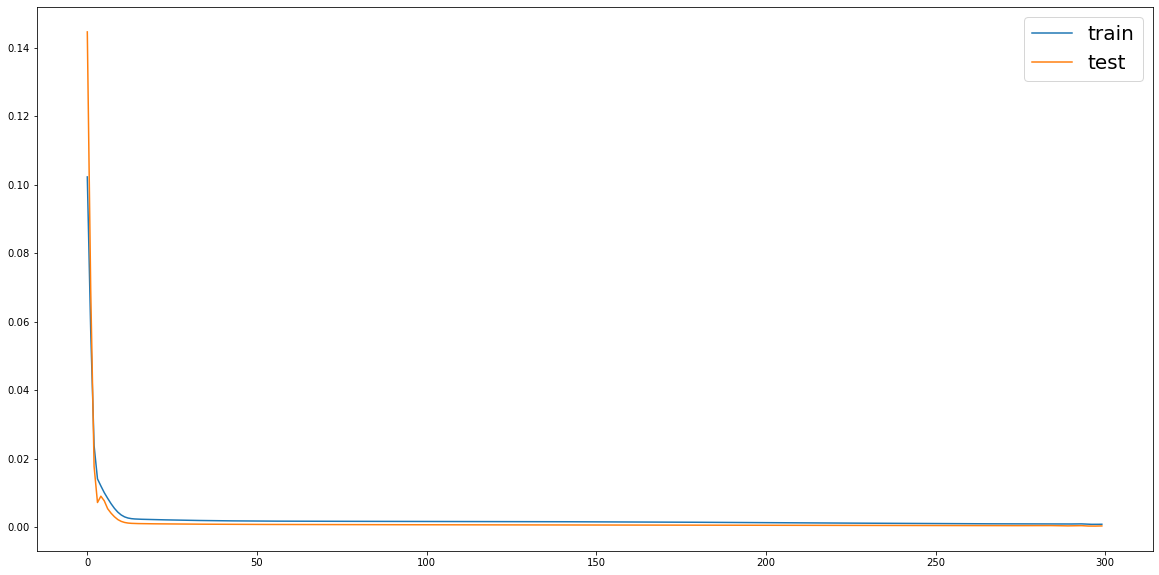

In [410]:
plt.rc('figure', figsize=(20, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(prop={'size': 20})
plt.show()

In [411]:
# make predictions
trainPredict = model.predict(trainX)



In [412]:
testPredict = model.predict(testX)

In [413]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


In [414]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 418.19 RMSE
Test Score: 290.49 RMSE
